# HERORY

This is the HERORY notebook for showcase

In this notebook, you will need to download the pre-trained models from Google drive in the following shared link: [google drive](https://drive.google.com/file/d/1mrLCXajiIeTTUC73EpW4mleMDCTpdso-/view?usp=sharing)

The structure of the saves folder:

```
saves
└───gpt-neo
│   │   ...
|   |   pytorch_model.bin (model)
│   └─── ...
|
└───lstm
    │   ...
    │   parameters.json (model parameters)
    |   word_dict.json (word dictionary)
    |   lastest.pth (model state dictionary)
    └─── ...
```

After downloading the pre-trained models, put the compressed file into the project directory (same directory as this notebook), run the following cells to decompress the folders.

In [ ]:
# decompress the compressed file into the 'saves' folder
!tar xvzf saves.tar.gz

## Loading models

### Unidirectional LSTM model from HERORY

In [1]:
import torch
from herory.data import Tokenizer, FileLoader
from herory.model import LSTM, get_model_parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize tokenizer
tokenizer = Tokenizer()

# initialize file folder
fl = FileLoader(tokenizer=tokenizer)

# load word dictionary to tokenizer
fl.load_exist_dict(path='./saves/lstm/word_dict.json')

# load model parameters
parameters = get_model_parameters(path="./saves/lstm/parameters.json")

# initialize model (LSTM)
lstm = LSTM(
    num_vocab=parameters['num_vocab'],
    hidden_size=parameters['hidden_size'],
    embedding_dim=parameters['embedding_dim'],
    num_layers=parameters['num_layers'],
    device=device
    )

# load model
lstm.load_state_dict(torch.load('./saves/lstm/lastest.pth'))

checkpoints_dir = parameters['checkpoints_dir']

Loading existing word dictionary from ./saves/lstm/word_dict.json ...


### GPT-Neo model
GPT-Neo 125M pararmeters

In [2]:
from happytransformer import HappyGeneration

generator = HappyGeneration(load_path="./saves/gpt-neo")

04/21/2022 21:42:28 - INFO - happytransformer.happy_transformer -   Using model: cuda


## Evaluation and results

### Losses for LSTM model

In [5]:
import os

losses_files = []
avg_losses_files = []

for file in os.listdir('./saves/lstm'):
    if file.split('-')[-1] == 'losses.pt':
        losses_files.append((int(file.split('-')[0]), file))
    if file.split('-')[-1] == 'avg_losses.pt':
        avg_losses_files.append((int(file.split('-')[0]), file))

losses_files.sort()
avg_losses_files.sort()

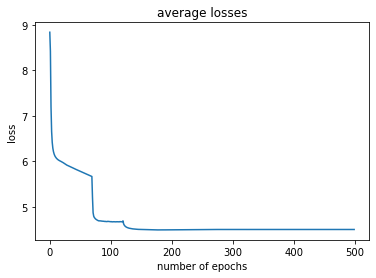

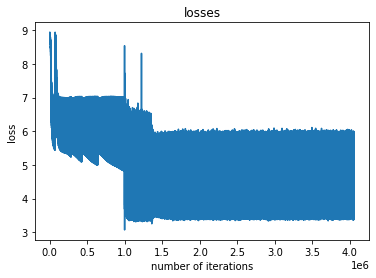

In [6]:
import matplotlib.pyplot as plt
import os

avg_losses = []
for _, file in avg_losses_files:
    avg_losses += torch.load(os.path.join(checkpoints_dir, file))

plt.title('average losses')
plt.plot(avg_losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show()

losses = []
for _, file in losses_files:
    losses += torch.load(os.path.join(checkpoints_dir, file))

plt.title('losses')
plt.plot(losses)
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.show()

### Results on both models

In [15]:
input_text = input()

print('Your input:', input_text)

Your input: the devil


#### Unidirectional LSTM model

In [16]:
import numpy as np
import torch.nn.functional as F
import time

def predict(model, tokenizer, text, device='cpu', max_length=None):
    start = time.time()
    
    model.to(device)
    model.eval()

    input_seq = tokenizer.text_to_sequence(text)
    state_h, state_c = model.init_state(len(input_seq))

    index = 0
    while input_seq[-1] != tokenizer.get_end_token_index():
        x = torch.tensor([input_seq[index:]]).to(device)
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = F.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        input_seq.append(word_index)
        
        if max_length !=None and index >= max_length:
            break
        
        index += 1

    time_taken = time.time() - start
    return tokenizer.sequence_to_text(input_seq), time_taken

res_lstm = predict(lstm, tokenizer, input_text, device=device, max_length=200)

print(res_lstm[0])

the <unk> ; but as usual so making his son , without into it . the ways gave some use back they were born ; hoo the sultan , and threw hold for snaky arm near and treated that the bushes was thinking their head . but reported the dragon of what that nobody else the hollow village than nothing up above the same rest heeding than the prince . now ventured darted for a dagger was quite rid of his wife . ' oh , as they are welcomed you , when the alarmed is a leather throne , o wretched why am i sang breathless ? ' the close led in the moment the mouse , one of which was very dangerous into the edge and the money could not buy a language . meanwhile the purse . ' but what is the cock could think for us , as smart to this well . ' as he was living . on the palace ' s life , when they came to the rather ride the man as very as though we shall know . ' the quite baby the holy of his mother embroidery by the listening further with his


#### GPT-Neo model

In [17]:
from happytransformer import GENSettings
import time

def gen_text(text):
    start = time.time()
    
    # text generation settings
    generic_sampling_settings = GENSettings(do_sample=True, top_k=0, temperature=0.9,  max_length=200)

    output_generic_sampling = generator.generate_text(text, args=generic_sampling_settings)
    
    time_taken = time.time() - start
    return input_text + output_generic_sampling.text, time_taken

res_gpt = gen_text(input_text)

print(res_gpt[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


the devil of God! Upon this the youth knew not what had been the cause ofhis separation; and he charged his father to keep the secret of the man to him, andto tell him that he had removed the enchanted city from his mother.So the man returned to his mother, and related to her theevent that had just befallen him, and thathis father had been lost from the battlements and slain by the black damsel, and thathis mother had been slain in a mountain and his father's death. Shewas then surrounded by people, and the Khaleefeh with his entirereason was moved to compassion for her, and he asked her advice, andacquainted her with his father's death. She replied, I know nothing of any one.'And so saying, he left her, and repented to return to her father,and informed her that he was ready to marry her on the same conditions asbefore, and that he would choose in what his father would


### Text generation difference
Since GPT-Neo model has 125 million parameters, the text generation time is much long than the LSTM model

In [18]:
time_diff = res_gpt[1] - res_lstm[1]

print('text generation time difference: ', time_diff, 's')

text generation time difference:  2.0348219871520996 s


While GPT-Neo model can only generate fixed length of texts, the HERORY model can generate a story with `<end>` token, which means the model can determine whether the story is ended.

In [19]:
res_lstm = predict(lstm, tokenizer, input_text, device=device, max_length=None)
print(res_lstm[0])

the <unk> he came to see the for rigging and moved , and he left ; ' now knocked it is good he were dying by milk ? still to pasture . he would be dreaming ! ' she said , ' she took the day that i go up you see for you . ' the old man it from one morning he returned , and he saw that of meat a night , when he said : ' here says , not to think , ' but the knelt never or shot , ' i have a big fire till you will he was turned , now sticks till not ask her in seeing up , but as her horse grew to him at this occasion to the country and put their son , they were to be able to not bear , as she did you carry him , saying , ' he asked , shaking as the king had burnt the tree had plainly strong behind him . when he girdle secretly in vain of which he crown , as not leant , and then she noticed a plan of their honour if he ' s out ; next neighbour was very hungry without again , was almost the servant was getting fly quickly , whom these words to tell way the checked all he could not like turned